In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1bc61d7e0c8>)

In [9]:
import os 
path = os.getcwd()
train_data = pd.read_table(path + '/ratings_train.txt')
test_data = pd.read_table(path + '/ratings_test.txt')

## 전처리

In [10]:
import re 
def clean_text(texts): 
    # tag 특수문자 제거
    review = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》;]', '', texts)
    # review = re.sub(r'\d+','', str(texts[i]))# remove number 
    # 한글 제외 제거
    review = re.sub('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', review)
    # 띄어쓰기 제거
    review = re.sub(r'\s+', ' ', review) 
    # html tag 제거
    review = re.sub(r'<[^>]+>','',review)
    # 시작 스페이스 제거
    review = re.sub(r"^\s+", '', review) 
    # 끝 스페이스 제거
    review = re.sub(r'\s+$', '', review) 
    return review

In [11]:
# 중복제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [12]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [13]:
train_data['document'] = train_data['document'].apply(lambda x: clean_text(str(x)))
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any')

id            0
document    790
label         0
dtype: int64


In [ ]:
# 맞춤법 검사

In [14]:
# 전처리 샘플
sample = train_data['document'][1]

In [15]:
from hanspell import spell_checker

print("전 : ", sample)
print("후 : ", spell_checker.check(sample).checked)

전 :  흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
후 :  흠포스터보고 초등학생영화 줄 오버 연기조차 가볍지 않구나


In [ ]:
# 맞춤법 검사
train_data['document'] = train_data['document'].apply(lambda x:spell_checker.check(x).checked)

In [14]:
# 품사 태깅

from konlpy.tag import Okt

okt = Okt()

# OKT
print('OKT 형태소 분석 :',okt.morphs(sample))
print('OKT 품사 태깅 :',okt.pos(sample))
print('OKT 명사 추출 :',okt.nouns(sample)) 

OKT 형태소 분석 : ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나']
OKT 품사 태깅 : [('흠', 'Noun'), ('포스터', 'Noun'), ('보고', 'Noun'), ('초딩', 'Noun'), ('영화', 'Noun'), ('줄', 'Noun'), ('오버', 'Noun'), ('연기', 'Noun'), ('조차', 'Josa'), ('가볍지', 'Adjective'), ('않구나', 'Verb')]
OKT 명사 추출 : ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기']


In [ ]:
from soynlp.noun import LRNounExtractor_v2

noun_extractor = LRNounExtractor_v2(verbose=True)
nouns = noun_extractor.train_extract(sample)
print(nouns)

[Noun Extractor] use default predictors
[Noun Extractor] num features: pos=3929, neg=2321, common=107
[Noun Extractor] counting eojeols
[EojeolCounter] n eojeol = 24 from 33 sents. mem=0.891 Gb                    
[Noun Extractor] complete eojeol counter -> lr graph
[Noun Extractor] has been trained. #eojeols=30, mem=0.891 Gb
[Noun Extractor] batch prediction was completed for 0 words
[Noun Extractor] checked compounds. discovered 0 compounds
[Noun Extractor] postprocessing detaching_features : 0 -> 0
[Noun Extractor] postprocessing ignore_features : 0 -> 0
[Noun Extractor] postprocessing ignore_NJ : 0 -> 0
[Noun Extractor] 0 nouns (0 compounds) with min frequency=1
[Noun Extractor] flushing was done. mem=0.891 Gb                    
[Noun Extractor] 0.00 % eojeols are covered
{}


In [ ]:
from soynlp.normalizer import *
print(train_data['document'][5])
print(emoticon_normalize(train_data['document'][5], num_repeats=2))

막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.


In [ ]:
print(train_data['document'][5])
print(repeat_normalize(train_data['document'][5], num_repeats=2))

막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.


## 불용어

In [40]:
# base
stop_words=set(['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한'])

## 단어표현

*   항목 추가
*   항목 추가



In [17]:
import numpy as np
import pandas as pd

In [36]:
# 
okt = Okt()
stop_words=set(['은','는','이','가','하','아','것','들','의','있','되','수','보','주','등','한'])

def preprocess(sentence):
    word_to_id = {}
    id_to_word = {}

    # 토큰화
    token = [okt.morphs(words) for words in sentence if isinstance(words, str)]

    # 불용어
    for i, words in enumerate(token):
        token[i] = [word for word in words if not word in stop_words]
    
    # word2dict
    for words in token:
        for word in words:
            if  word not in word_to_id.keys():
                new_id = len(word_to_id)
                word_to_id[word] = new_id
                id_to_word[new_id] = word 
    
    # 말뭉치
    corpus_ar = []
    for words in token:
        for word in words:
            corpus = [word_to_id[word] for word in words]
        corpus_ar.append(corpus)
    del corpus
    return np.array(corpus_ar), word_to_id, id_to_word, token

In [18]:
def create_co_metirx(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

def cos_similarity(x, y, e=1e-8):
    nx = x / (np.sqrt(np.sum(x ** 2)) + e)
    ny = y / (np.sqrt(np.sum(y ** 2)) + e)
    return np.dot(nx, ny)

In [20]:
#유사도 측정
vocab_size = len(word_to_id)
C = create_co_metirx(corpus[1], vocab_size) 

c0 = C[word_to_id['흠']]
c1 = C[word_to_id['가볍지']]
print(cos_similarity(c0, c1))

0.0


## 데이터 평균 길이 확인

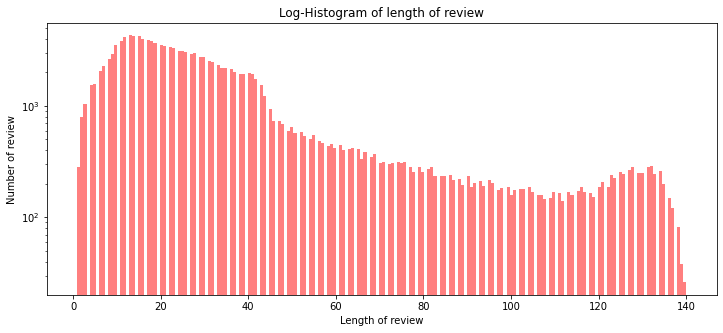

In [39]:
# 문장 평균 길이
plt.figure(figsize=(12,5))

plt.hist(train_data['document'].astype(str).apply(len), bins=200, alpha=0.5, color='r', label='word')
plt.yscale('log',nonposy='clip')
plt.title('Log-Histogram of length of review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')
plt.show()

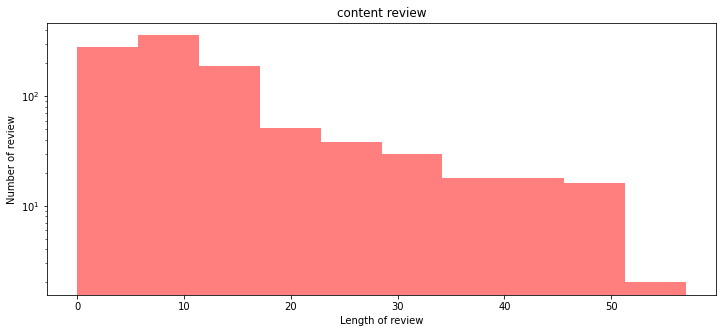

In [38]:
# 단어 평균 개수
plt.figure(figsize=(12,5))

plt.hist([len(words) for words in token], alpha=0.5, color='r', label='word')
plt.yscale('log',nonposy='clip')
plt.title('content review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')
plt.show()

# bocab -> 50으로 결정!

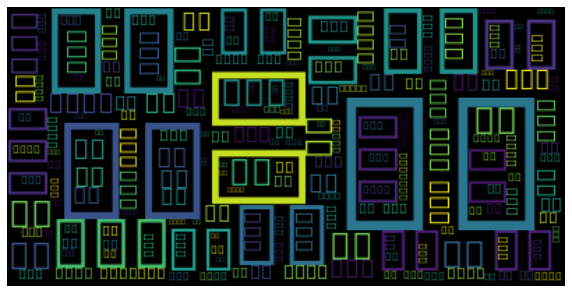

In [30]:
# 단어 구성 보기
from wordcloud import WordCloud
wordcloud=WordCloud().generate(' '.join(train_data['document'][:1000]))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# 단어 사전 크기

tokenizer = Tokenizer()
tokenizer.fit_on_texts(token)

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
vocab_size = total_cnt - rare_cnt + 1
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(token)
X_train = tokenizer.texts_to_sequences(token)